In this part, the data from GSE55763 will be imported, quality-checked, and structured to facilitate downstream analysis.

In [2]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [56]:
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

Download SOFT file

In [64]:
gse = GEOparse.get_GEO(geo="GSE55763", destdir="./data", silent=True, how="full")

C:\Users\Owner\anaconda3\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (11,14,15,36) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


In [65]:
print(list(gse.gsms.keys())[:3])

['GSM1343050', 'GSM1343051', 'GSM1343052']


In this case, GSM1343050, GSM1343051, GSM1343052 are sample IDs.

In [67]:
print("The number of samples is:", len(gse.gsms))

The number of samples is: 2711


Explore the metadata of the samples in GSE55763
The keys of metadata are the names of the fields extracted from characteristics_ch1

In [69]:
metadata = {}
for gsm_name, gsm in gse.gsms.items():
    for key, value in gsm.metadata.items():
        if key == 'characteristics_ch1':
            tmpVal = 0
            for tmp in value:
                splitUp = [i.strip() for i in tmp.split(':')]
                if len(splitUp) == 2:
                    if not splitUp[0] in metadata:
                        metadata[splitUp[0]] = {}
                    metadata[splitUp[0]][gsm_name] = splitUp[1]


In [82]:
df_metadata = pd.DataFrame(metadata)

In [84]:
df_metadata = df_metadata.transpose() ## Transpose the DataFrame so that samples are rows and metadata fields are columns

In [86]:
print(df_metadata.head(3))   # display the first 3 rows

                                            GSM1343050  \
tissue                                peripheral blood   
dataset  population study; technical replication study   
gender                                               M   

                                            GSM1343051  \
tissue                                peripheral blood   
dataset  population study; technical replication study   
gender                                               M   

                                            GSM1343052  \
tissue                                peripheral blood   
dataset  population study; technical replication study   
gender                                               M   

                          GSM1343053                   GSM1343054  \
tissue              peripheral blood             peripheral blood   
dataset  technical replication study  technical replication study   
gender                             M                            M   

                        

In [88]:
print(df_metadata.columns)

Index(['GSM1343050', 'GSM1343051', 'GSM1343052', 'GSM1343053', 'GSM1343054',
       'GSM1343055', 'GSM1343056', 'GSM1343057', 'GSM1343058', 'GSM1343059',
       ...
       'GSM1345751', 'GSM1345752', 'GSM1345753', 'GSM1345754', 'GSM1345755',
       'GSM1345756', 'GSM1345757', 'GSM1345758', 'GSM1345759', 'GSM1345760'],
      dtype='object', length=2711)


In [94]:
# Transpose so samples become rows
df_metadata = df_metadata.set_index("gsm").transpose()

# Reset index so GSM IDs are a column
df_metadata.reset_index(inplace=True)
df_metadata.rename(columns={"index": "gsm"}, inplace=True)

# Rename columns to something clean
df_metadata.rename(columns={
    "gender": "sex",
    "tissue": "tissue",
    "age": "age"
}, inplace=True)

# Convert age to numeric
df_metadata["age"] = pd.to_numeric(df_metadata["age"], errors="coerce")

print(df_metadata.head())
print(df_metadata.dtypes)


gsm         gsm            tissue  \
0    GSM1343050  peripheral blood   
1    GSM1343051  peripheral blood   
2    GSM1343052  peripheral blood   
3    GSM1343053  peripheral blood   
4    GSM1343054  peripheral blood   

gsm                                        dataset sex   age  
0    population study; technical replication study   M  57.9  
1    population study; technical replication study   M  42.0  
2    population study; technical replication study   M  47.4  
3                      technical replication study   M  49.3  
4                      technical replication study   M  52.5  
gsm
gsm         object
tissue      object
dataset     object
sex         object
age        float64
dtype: object


In [96]:
df_metadata['age'] = pd.to_numeric(df_metadata['age'], errors='coerce') # convert to numeric for further analysis
print(df_metadata['age'].describe().round(2)) # Summary statistics and round to 2 digits

count    2711.00
mean       51.02
std        10.09
min        23.70
25%        43.20
50%        50.20
75%        57.60
max        75.00
Name: age, dtype: float64


In [98]:
print("Median age:", df_metadata['age'].median()) # Calculate the median
print("Mode age:", df_metadata['age'].mode().to_list()) #Calculate a mode and store its a list

Median age: 50.2
Mode age: [35.1, 35.2]


In [100]:
display(df_metadata['dataset'].value_counts())

dataset
population study                                 2639
technical replication study                        47
population study; technical replication study      25
Name: count, dtype: int64

Data visualization

The variable age is represented using a histogram, which displays the distribution of ages across all samples in the dataset.

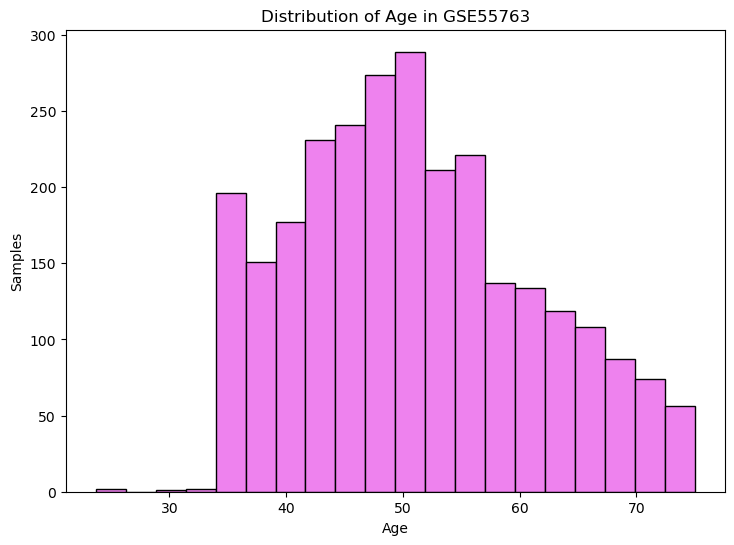

In [104]:
plt.figure(figsize=(8.5, 6))
plt.hist(df_metadata['age'], bins=20, color='violet', edgecolor='black')
plt.title('Distribution of Age in GSE55763')
plt.xlabel('Age')
plt.ylabel('Samples')
plt.show()

An alternative way to visualize this variable is with a density plot, which shows the distribution and relative frequency of values across the dataset.

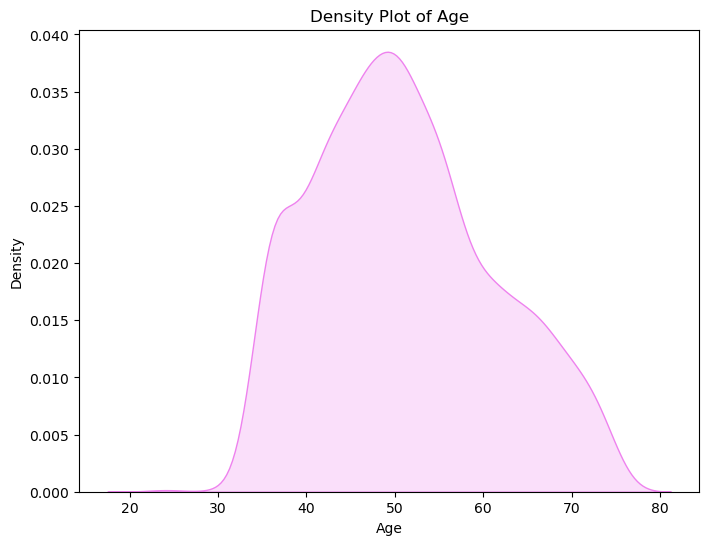

In [107]:
plt.figure(figsize=(8,6))
sns.kdeplot(df_metadata['age'], fill=True, color='violet')
plt.title('Density Plot of Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_27148\582228844.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


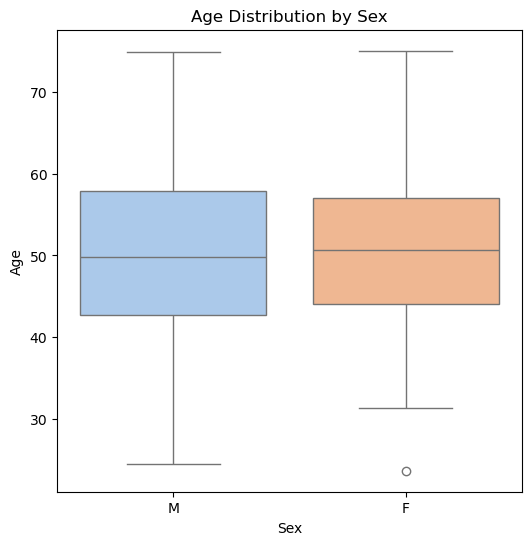

In [133]:
plt.figure(figsize=(6,6))
sns.boxplot(x='sex', y='age', hue='sex', data=df_metadata, palette='pastel', dodge=False)
plt.title("Age Distribution by Sex")
plt.xlabel("Sex")
plt.ylabel("Age")
plt.legend().remove()
plt.show()

In [ ]:
gender_table = pd.DataFrame({
    'Count': df_metadata['gender'].value_counts(),
    'Percentage (%)': (df_metadata['gender'].value_counts(normalize=True) * 100).round(1)
})

display(gender_table)

For the variable gender, which is categorical, the distribution is visualized using a bar plot.

Verification of Gender as a Categorical Variable

In [116]:
print(df_metadata['sex'].unique())


['M' 'F']


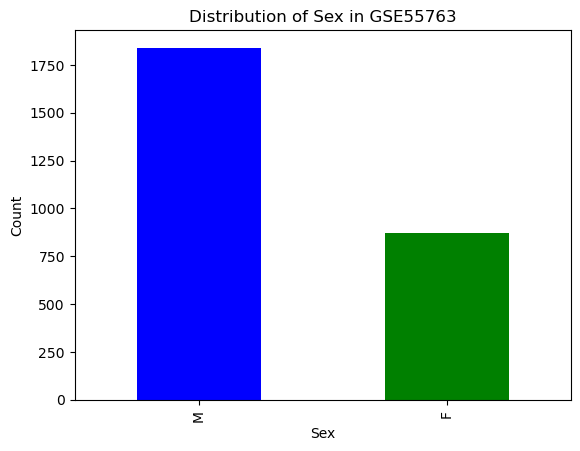

In [129]:
# Count the number of males and females
gender_table = df_metadata['sex'].value_counts().reset_index()
gender_table.columns = ['Sex', 'Count']

# Plot
gender_table.plot(kind='bar', x='Sex', y='Count', color=['blue', 'green'], legend=False)
plt.title("Distribution of Sex in GSE55763")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

Outlier analysis is performed on the age variable to identify extreme values that could influence downstream analyses. Outliers are defined using the interquartile range (IQR) method, where values below Q1 − 1.5×IQR or above Q3 + 1.5×IQR are considered outliers

In [131]:
age = df_metadata['age'].dropna()  # ignore missing values

Q1 = np.percentile(age, 25)
Q3 = np.percentile(age, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = age[(age < lower) | (age > upper)]

print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
print("Outliers:", outliers.values)

Lower bound: 21.60, Upper bound: 79.20
Outliers: []


Extract beta-values

Phenotypes

In [125]:
# Ver phenotypes
pheno = gse.phenotype_data
pheno.index.name = "subject_id"
print(pheno.head())

# Ver información de los archivos suplementarios de cada GSM
for gsm_name, gsm in gse.gsms.items():
    if hasattr(gsm, 'supplementary_file'):
        print(gsm_name, gsm.supplementary_file)

                                          title geo_accession  \
subject_id                                                      
GSM1343050  Peripheral blood, 7786915023_R02C02    GSM1343050   
GSM1343051  Peripheral blood, 7786915135_R04C02    GSM1343051   
GSM1343052  Peripheral blood, 7471147149_R06C01    GSM1343052   
GSM1343053  Peripheral blood, 7786915035_R05C01    GSM1343053   
GSM1343054  Peripheral blood, 7786923035_R01C01    GSM1343054   

                           status submission_date last_update_date     type  \
subject_id                                                                    
GSM1343050  Public on Jan 22 2015     Mar 10 2014      Mar 03 2015  genomic   
GSM1343051  Public on Jan 22 2015     Mar 10 2014      Mar 03 2015  genomic   
GSM1343052  Public on Jan 22 2015     Mar 10 2014      Mar 03 2015  genomic   
GSM1343053  Public on Jan 22 2015     Mar 10 2014      Mar 03 2015  genomic   
GSM1343054  Public on Jan 22 2015     Mar 10 2014      Mar 03 2015  ge

Cohort summary table

In [135]:
cohort_summary = pd.DataFrame({
    "Total Samples": [len(df_metadata)],
    "Mean Age": [df_metadata["age"].mean()],
    "Median Age": [df_metadata["age"].median()],
    "Min Age": [df_metadata["age"].min()],
    "Max Age": [df_metadata["age"].max()],
    "Male Count": [sum(df_metadata["sex"] == "M")],
    "Female Count": [sum(df_metadata["sex"] == "F")]
})


   Total Samples   Mean Age  Median Age  Min Age  Max Age  Male Count  \
0           2711  51.016673        50.2     23.7     75.0        1840   

   Female Count  
0           871  


In [137]:
cohort_summary.style.background_gradient(cmap='Blues').format({
    "Mean Age": "{:.1f}",
    "Median Age": "{:.1f}",
    "Min Age": "{:.1f}",
    "Max Age": "{:.1f}"
})

,Total Samples,Mean Age,Median Age,Min Age,Max Age,Male Count,Female Count
0,2711,51.0,50.2,23.7,75.0,1840,871
